# B⁺ Yield Ratio Stability Analysis (Blocks)

Perform temporal stability analysis of B⁺ decay yields across different data-taking periods to monitor detector and reconstruction performance.

## Analysis Overview

• **Purpose**: Monitor systematic variations in B⁺ → D⁰π⁺ / B⁺ → J/ψK⁺ yield ratios across blocks
• **Method**: Extract fitted yields from `fit_results` trees and calculate ratios with propagated uncertainties  
• **Statistical Test**: Constant fit to ratios tests temporal stability (χ²/ndf goodness-of-fit)
• **Output**: Stability plots, fit parameters, and statistical summary of variations

## Important Notes

• **B2OC Files**: Uses `nsig` branch for B⁺ → D⁰π⁺ signal yield
• **B2CC Files**: Uses `njpsik` branch for B⁺ → J/ψK⁺ signal yield (not total signal)
• **Error Propagation**: Proper quadrature sum for uncertainties in ratios and fits
• **Blocks**: Data organized by time periods (UP/DOWN magnet polarity per block) 


In [20]:
# Importing required functions
import ROOT as r                           
import numpy as np                         
import matplotlib.pyplot as plt             
from scipy.optimize import curve_fit
from pathlib import Path

DATA_CLEAN = Path("data/processed_clean_bp_p")  # Directory containing processed ROOT files

# Input files for B⁺ → D⁰π⁺ and B⁺ → J/ψK⁺ analysis
b2oc_files = [
    DATA_CLEAN/"2024_B2OC_B5.root",
    DATA_CLEAN/"2024_B2OC_B6.root", 
    DATA_CLEAN/"2024_B2OC_B7.root",
    DATA_CLEAN/"2024_B2OC_B8.root"
]
b2cc_files = [
    DATA_CLEAN/"2024_B2CC_B5.root",
    DATA_CLEAN/"2024_B2CC_B6.root",
    DATA_CLEAN/"2024_B2CC_B7.root", 
    DATA_CLEAN/"2024_B2CC_B8.root"
]

blocks = [5, 6, 7, 8]                       

def get_yield_with_error_from_file(filename, yield_branch='nsig', error_branch='nsig_err'):
    """
    Extract yield and error from ROOT file fit_results tree
    For B2OC files: uses 'nsig' and 'nsig_err' branches  
    For B2CC files: uses 'njpsik' and 'njpsik_err' branches for J/ψK yield
    """
    try:
        file = r.TFile.Open(str(filename))   
        if not file or file.IsZombie():
            print(f"Cannot open {filename}")
            return 0, 0
            
        # Access fit_results tree containing fitted parameters
        tree = file.Get("fit_results")
        if not tree:
            print(f"fit_results tree not found in {filename}")
            file.Close()
            return 0, 0
        
        # Extract yield and error values from specified branches
        yield_values = []
        error_values = []
        
        for i in range(tree.GetEntries()):
            tree.GetEntry(i)
            yield_val = getattr(tree, yield_branch, 0)
            error_val = getattr(tree, error_branch, 0)
            yield_values.append(yield_val)
            error_values.append(error_val)
        
        # Sum yields and propagate uncertainties
        total_yield = sum(yield_values)
        total_error = np.sqrt(sum(err**2 for err in error_values))  
            
        file.Close()
        return total_yield, total_error
            
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return 0, 0

# Extract yields for each block with proper branch names
print("Extracting yields from block files...")
b2oc_yields = []
b2oc_errors = []
b2cc_yields = []
b2cc_errors = []

for i, block in enumerate(blocks):
    print(f"\nBlock {block}:")
    
    # B⁺ → D⁰π⁺ yield and error (uses nsig branch)
    b2oc_yield, b2oc_error = get_yield_with_error_from_file(b2oc_files[i], 'nsig', 'nsig_err')
    b2oc_yields.append(b2oc_yield)
    b2oc_errors.append(b2oc_error)
    print(f"  B2OC yield: {b2oc_yield:.2f} ± {b2oc_error:.2f}")
    
    # B⁺ → J/ψK⁺ yield and error (uses njpsik branch for J/ψK signal)
    b2cc_yield, b2cc_error = get_yield_with_error_from_file(b2cc_files[i], 'njpsik', 'njpsik_err')
    b2cc_yields.append(b2cc_yield)
    b2cc_errors.append(b2cc_error)
    print(f"  B2CC yield: {b2cc_yield:.2f} ± {b2cc_error:.2f}")

# Calculate yield ratios with uncertainty propagation
b2oc_yields = np.array(b2oc_yields)
b2oc_errors = np.array(b2oc_errors)
b2cc_yields = np.array(b2cc_yields)
b2cc_errors = np.array(b2cc_errors)

ratios = b2oc_yields / b2cc_yields
plotting_ratios = ratios

# Error propagation for ratios: σ_R = R * sqrt((σ_A/A)² + (σ_B/B)²)
ratio_errors = ratios * np.sqrt((b2oc_errors/b2oc_yields)**2 + (b2cc_errors/b2cc_yields)**2)
plotting_ratios_err = ratio_errors

print(f"\nYield ratios with propagated uncertainties:")
for i, block in enumerate(blocks):
    print(f"  Block {block}: {ratios[i]:.6f} ± {ratio_errors[i]:.6f}")

Extracting yields from block files...

Block 5:
  B2OC yield: 866695.48 ± 1993.87
  B2CC yield: 1216237.46 ± 2465.73

Block 6:
  B2OC yield: 709312.14 ± 1842.16
  B2CC yield: 1021107.64 ± 3879.46

Block 7:
  B2OC yield: 544306.21 ± 1739.05
  B2CC yield: 762731.10 ± 351.83

Block 8:
  B2OC yield: 325482.22 ± 1332.49
  B2CC yield: 458742.39 ± 303.89

Yield ratios with propagated uncertainties:
  Block 5: 0.712604 ± 0.002185
  Block 6: 0.694650 ± 0.003197
  Block 7: 0.713628 ± 0.002304
  Block 8: 0.709510 ± 0.002942


Weighted mean = 0.709461 ± 0.001279  (chi2/ndof = 26.81/3)


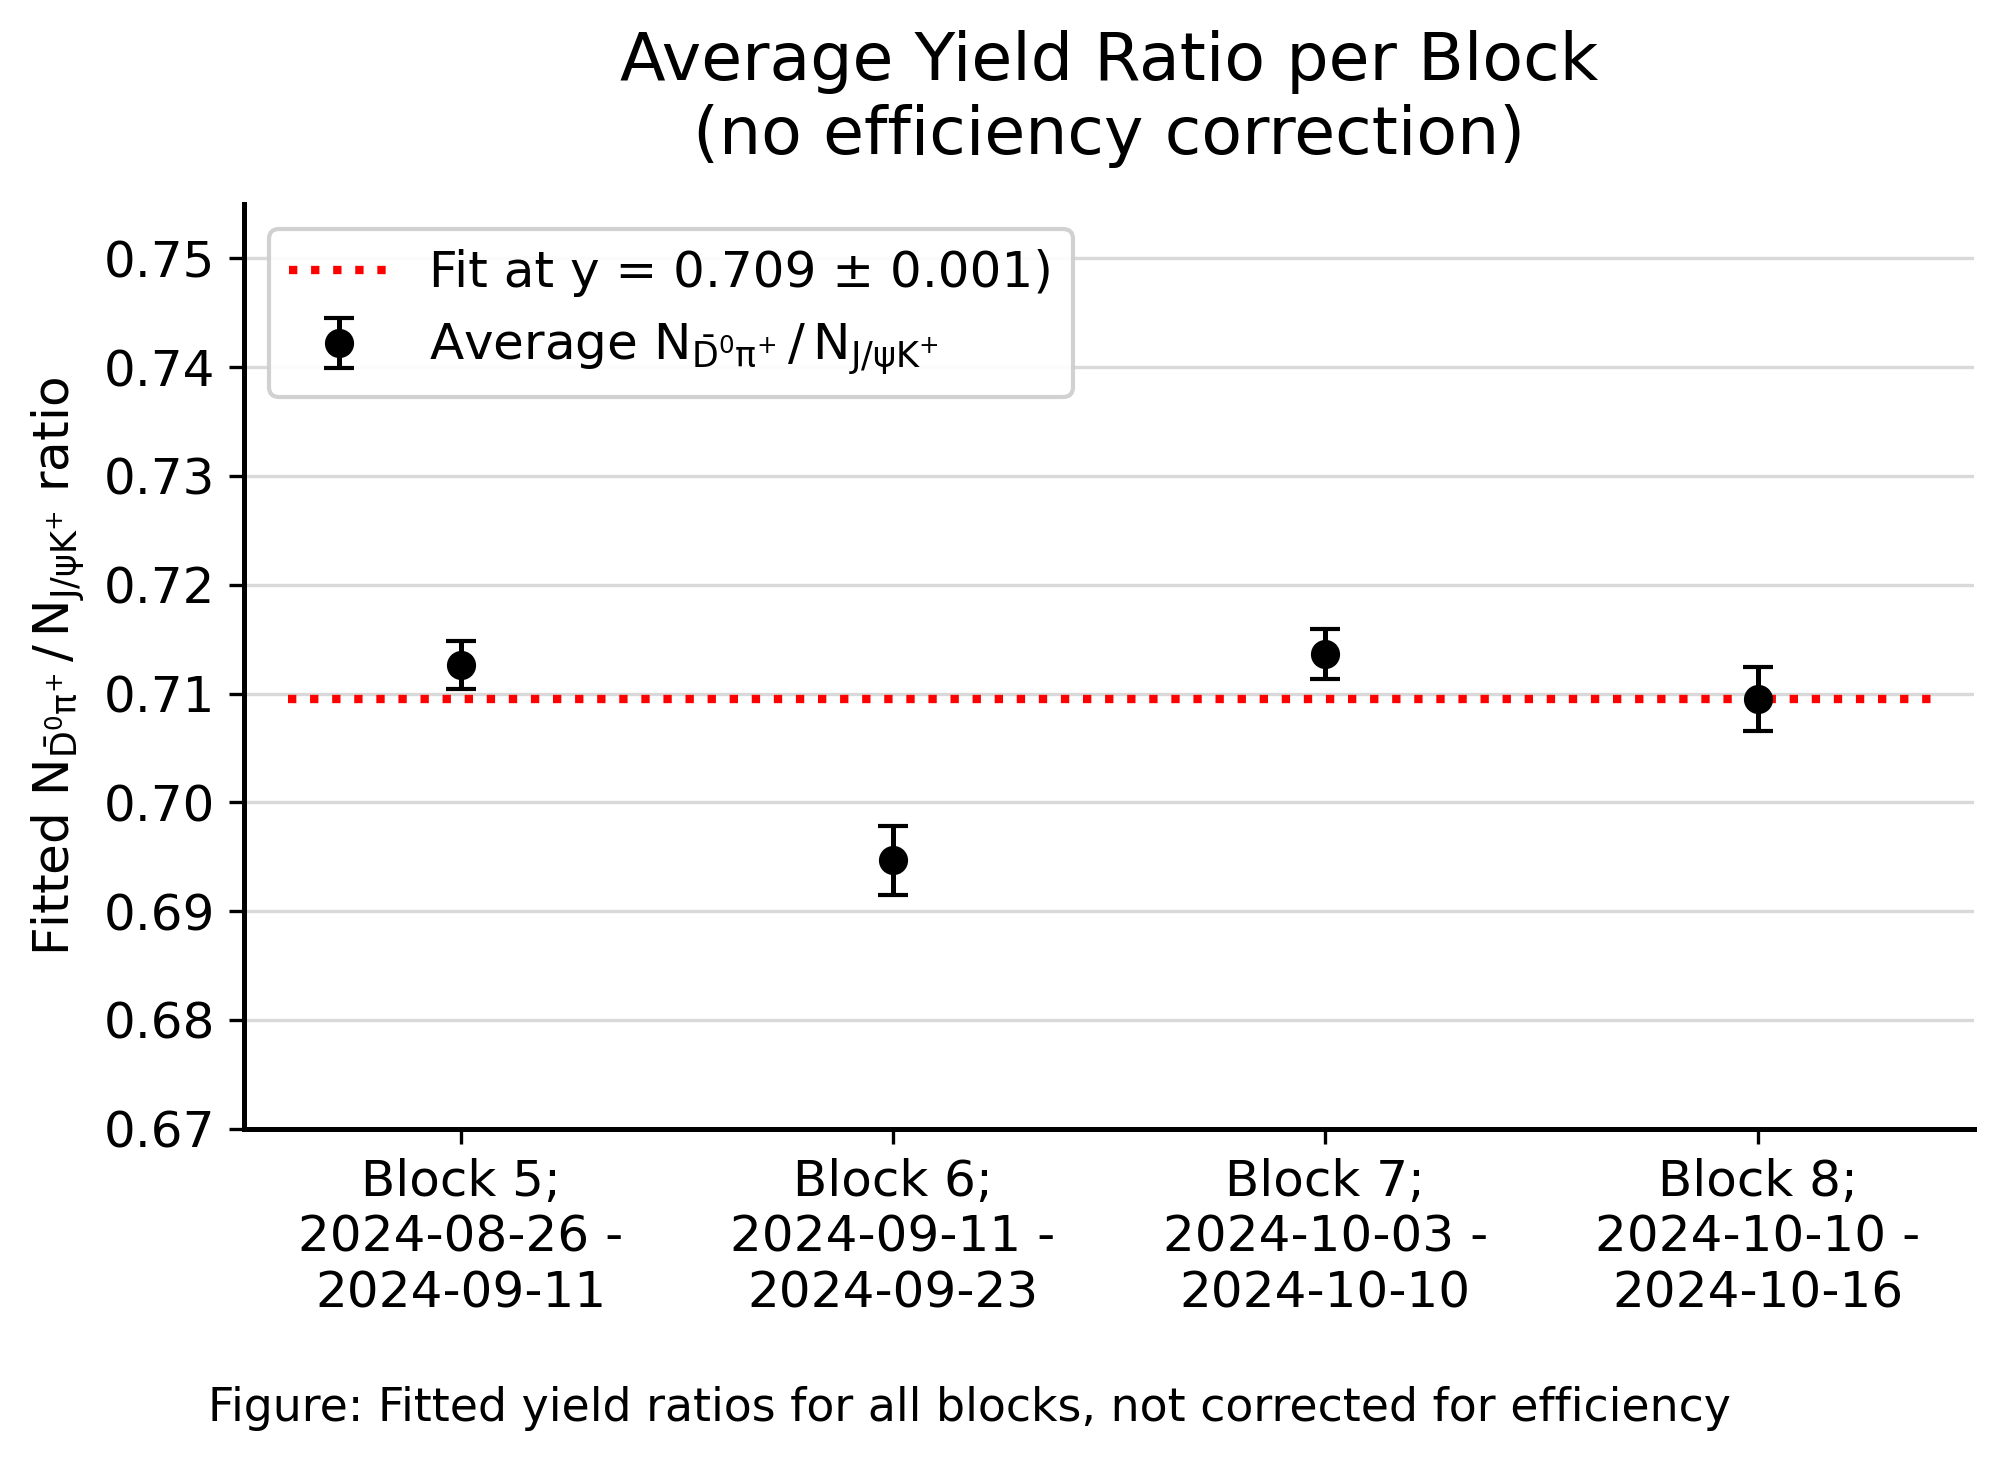

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def fit_constant(y, yerr):
    """Weighted constant fit: returns (ybar, ybar_err, chi2, ndof)."""
    y = np.asarray(y, dtype=float)
    yerr = np.asarray(yerr, dtype=float)
    w = 1.0 / (yerr**2)
    ybar = np.sum(w * y) / np.sum(w)
    ybar_err = np.sqrt(1.0 / np.sum(w))
    # chi2 for constant hypothesis
    chi2 = np.sum(((y - ybar) / yerr) ** 2)
    ndof = len(y) - 1
    return ybar, ybar_err, chi2, ndof

def plot_block_ratios(
    blocks,               # e.g. ["Block 5;\n2024-08-26 -\n2024-09-11", ...]
    plotting_ratios,               # central values per block
    plotting_ratios_err,           # 1σ uncertainties per block
    *,
    title=r"Average $N_{\bar{D}^{0}\pi^{+}} \,/\, N_{J/\psi K^{+}}$ per block",
    ylabel=r"Fitted $N_{\bar{D}^{0}\pi^{+}} \,/\, N_{J/\psi K^{+}}$ ratio",
    ylimits=(0.75, 0.835),   # change to taste
    caption="Figure: Fitted yield ratios for all blocks, not corrected for efficiency",
    figwidth=7.2, figheight=5.0,
    outfile=None          # e.g. "ratios_blocks.png"
):
    blocks = list(blocks)
    plotting_ratios = np.asarray(plotting_ratios, dtype=float)
    plotting_ratios_err = np.asarray(plotting_ratios_err, dtype=float)

    # --- constant fit
    ybar, ybar_err, chi2, ndof = fit_constant(plotting_ratios, plotting_ratios_err)
    #fit_label = f"Fit at y = {ybar:.3f} ± {ybar_err:.3f}   (χ²/ndof = {chi2:.2f}/{ndof})"
    fit_label = f"Fit at y = {ybar:.3f} ± {ybar_err:.3f})"

    # --- figure style
    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "axes.linewidth": 1.2,
        "axes.grid": True,
        "grid.color": "#C0C0C0",
        "grid.linestyle": "-",
        "grid.alpha": 0.6,
        "font.size": 12,
        "mathtext.default": "regular",
    })

    fig, ax = plt.subplots(figsize=(figwidth, figheight))

    # x positions
    x = np.arange(len(blocks))

    # errorbar points (black dots with vertical error bars)
    ax.errorbar(
        x, plotting_ratios, yerr=plotting_ratios_err,
        fmt="o", color="black", ecolor="black", elinewidth=1.2,
        capsize=3.5, markersize=6, label=r"Average $N_{\bar{D}^{0}\pi^{+}} \,/\, N_{J/\psi K^{+}}$"
    )

    # horizontal fitted line across full width
    ax.hlines(ybar, x.min()-0.4, x.max()+0.4, colors="red", linestyles="dotted", linewidth=2.0,
              label=fit_label)

    # axes cosmetics
    ax.set_xlim(-0.5, len(blocks)-0.5)
    if ylimits is not None:
        ax.set_ylim(*ylimits)

    ax.set_title(title, pad=12, fontsize=16)
    ax.set_ylabel(ylabel)

    # tick labels as multi-line block labels (keep the line breaks you pass in)
    ax.set_xticks(x, blocks)

    # light horizontal gridlines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)

    # clean spines
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # legend (white box with slight alpha)
    leg = ax.legend(loc="upper left", frameon=True)
    leg.get_frame().set_alpha(0.9)

    # caption under the plot
    fig.text(0.5, 0.01, caption, ha="center", va="bottom", fontsize=11)

    fig.tight_layout(rect=(0.04, 0.05, 0.99, 0.98))

    if outfile:
        fig.savefig(outfile, bbox_inches="tight")
    return fig, ax, (ybar, ybar_err, chi2, ndof)


# ---------- Example usage ----------
if __name__ == "__main__":
    blocks = [
        "Block 5;\n2024-08-26 -\n2024-09-11",
        "Block 6;\n2024-09-11 -\n2024-09-23",
        "Block 7;\n2024-10-03 -\n2024-10-10",
        "Block 8;\n2024-10-10 -\n2024-10-16",
    ]

    title = "Average Yield Ratio per Block\n(no efficiency correction)"

    caption = "Figure: Fitted yield ratios for all blocks, not corrected for efficiency"
    ylimits = (0.67, 0.755)  # tweak y-scale here

    fig, ax, fit = plot_block_ratios(
        blocks, plotting_ratios, plotting_ratios_err,
        title=title,
        caption=caption,
        ylimits=ylimits,
        outfile="block_ratios.png",
    )
    print(f"Weighted mean = {fit[0]:.6f} ± {fit[1]:.6f}  (chi2/ndof = {fit[2]:.2f}/{fit[3]})")
    plt.show()
